# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 1.03.2019
- Срок сдачи: 23:59 15.03.2019

In [35]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [36]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [37]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### (1 балл) Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [47]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [39]:
from sklearn.metrics import mean_squared_error
import random

In [40]:
def shuffle(X, y, N):
    ''' Для того, чтобы обучать СЛУЧАЙНЫЕ элементы,
        создадим список из всех индексов и перемешаем их,
        возьмём N первых получившихся индексов
        и будем работать уже с ними.
    '''
    indexes = list(range(len(X)))
    random.shuffle(indexes)
    X_train = []
    y_train = []
    for i in range(N):
        X_train.append(X[i])
        y_train.append(y[i])
        
    return X_train, y_train

In [48]:
err = []
LRs = []
for N in N_grid:
    X_train, y_train = shuffle(X, y, N)
    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X)
    err.append(mean_squared_error(y_gt, y_pred))
    LRs.append(LR)

Код для построения графиков:

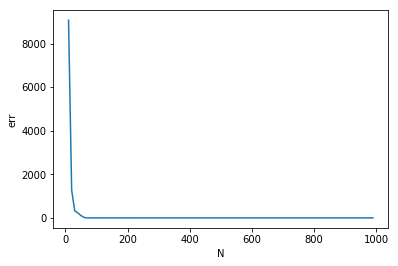

In [49]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

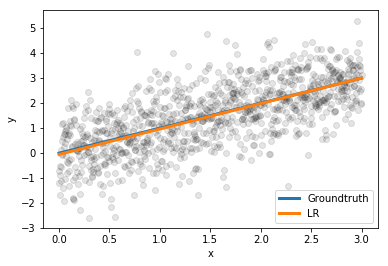

In [50]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Проделайте тоже самое для KNN при n_neighbors=3.

In [51]:
from sklearn.neighbors import KNeighborsRegressor

In [52]:
err = []
KNNs = []

for N in N_grid:
    X_train, y_train = shuffle(X, y, N)
        
    clf = KNeighborsRegressor(n_neighbors=3, metric='euclidean')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X)
    err.append(mean_squared_error(y_gt, y_pred))
    KNNs.append(clf)

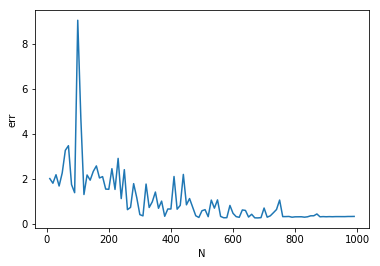

In [53]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

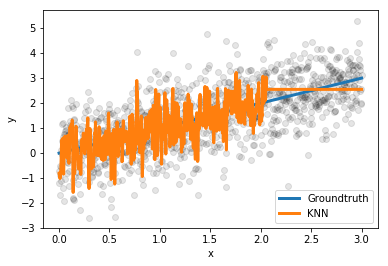

In [54]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

In [55]:
err = []
KNNs = []

for N in N_grid:
    X_train, y_train = shuffle(X, y, N)
    clf = KNeighborsRegressor(n_neighbors=10, metric='euclidean')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X)
    err.append(mean_squared_error(y_gt, y_pred))
    KNNs.append(clf)

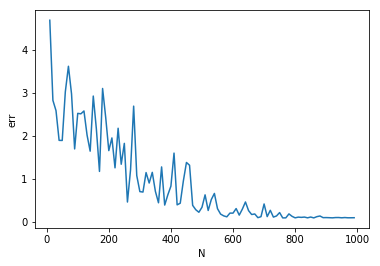

In [56]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

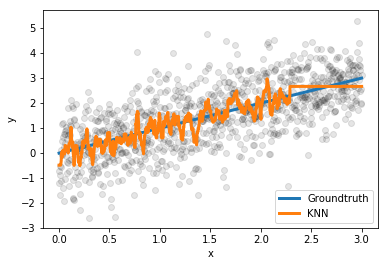

In [57]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

# Выводы

Проведённый эксперимент демонстрирует, что для конкретной задачи метод линейной регрессии оказывается наиболее подходящим. Регрессионная прямая оказывается визуально неотличимой от истинной прямой уже при N, чуть меньшим 100.

Отдельно можно отметить, что ни в одном из методов нет переобучения - во всех графиках при N, близком к 1000, число ошибок оказывается равным 0, при этом до этого наблюдается стремительное убывание прямой.

Если же сравнивать между собой KNN для 3 и 10 соседей, для конкретной задачи более релевантным оказывается метод 10 ближайших соседей.

#### (1 балл) Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        Poly = pp.PolynomialFeatures(degree=d_new)
        X_new = Poly.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [157]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [158]:
err_1 = []
LRs_1 = []
for N in N_grid:
    X_train, y_train = shuffle(X, y, N)
    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X)
    err_1.append(mean_squared_error(y_gt, y_pred))
    LRs_1.append(LR)

err_2 = []
LRs_2 = []
Poly = pp.PolynomialFeatures(degree=2)
X_new_2 = Poly.fit_transform(X)
for N in N_grid:
    X_train, y_train = shuffle(X_new_2, y, N)
    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_new_2)
    err_2.append(mean_squared_error(y_gt, y_pred))
    LRs_2.append(LR)

err_3 = []
LRs_3 = []
Poly = pp.PolynomialFeatures(degree=5)
X_new_3 = Poly.fit_transform(X)
for N in N_grid:
    X_train, y_train = shuffle(X_new_3, y, N)
    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_new_3)
    err_3.append(mean_squared_error(y_gt, y_pred))
    LRs_3.append(LR)

Код для построения всех графиков:

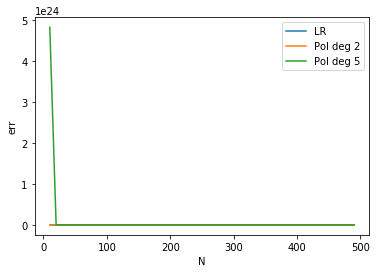

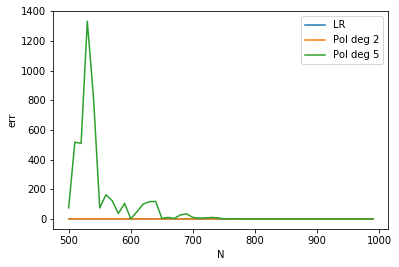

In [159]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

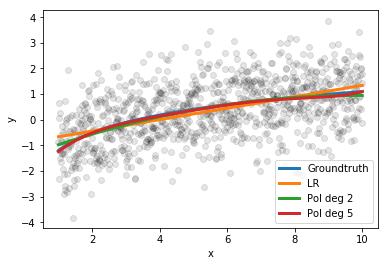

In [160]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

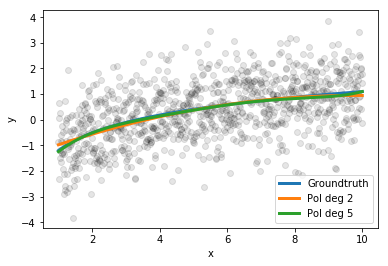

In [161]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

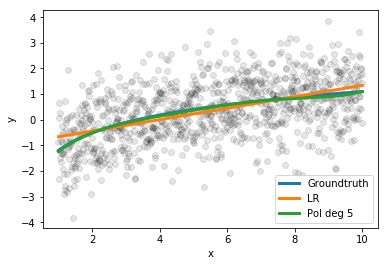

In [162]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Выводы

Проведённый эксперимент демонстрирует, поведение регрессии с полиномиальными признаками степени 2 оказывается схожим с поведением простой линейной регрессии, что, в принципе, и следовало ожидать, так как линейная регрессия является частным случаем полиномиальной регрессии.

Для конкретной задачи наиболее релевантным оказывается метод регрессии с полиномиальными признаками степени 5. Это можно объяснить тем, что точность приближения к реальной кривой будет повышаться с увеличением степени вплоть до переобучения. С помощью построенных графиков можно понять, что при p = 5 ещё нет переобучения, а потому именно при этой степени кривая оказывается более точной.

#### (1 балл) Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = Ridge.predict(X_train)

In [138]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [145]:
LR = lm.LinearRegression()
X_train, y_train = shuffle(X, y, N)
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X)

In [146]:
Ridge = lm.Ridge()
X_train, y_train = shuffle(X, y, N)
Ridge.fit(X_train, y_train)
y_pred_Ridge = Ridge.predict(X)

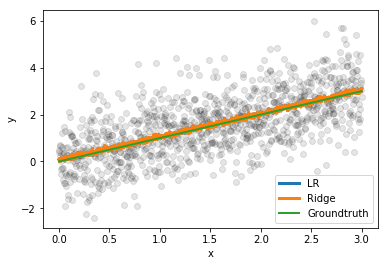

In [141]:
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

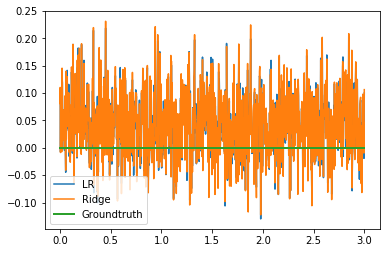

In [142]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [143]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

5.008865101480309
5.350733269711559


In [144]:
print(LR.coef_)
print(Ridge.coef_)

[[ 0.78243865 -0.06235746  0.1137314 ]]
[[0.55579685 0.04722173 0.11601258]]


# Выводы

MSE оказывается примерно одинаковыми для обоих методов; тем не менее, для линейной регрессии величина ошибки оказывается меньше, из чего можем сделать вывод, что этод метод оказывается всё же более релевантным для конкретной задачи.

Анализ получившихся весов признаков показывает, что оба методы оказываются достаточно хорошими. Распределение весов получается схожим - первый признак оказывается самым главным.

Близость методов демонстрируетя и с помощью визуализации полученных данных.

#### (1 балл) Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = Lasso.predict(X_train)

In [68]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [69]:
Ridge = lm.Ridge()
X_train, y_train = shuffle(X, y, N)
Ridge.fit(X_train, y_train)
y_pred_Ridge = Ridge.predict(X)

In [70]:
Lasso = lm.Lasso()
X_train, y_train = shuffle(X, y, N)
Lasso.fit(X_train, y_train)
y_pred_Lasso = Lasso.predict(X)

In [71]:
print(Lasso.coef_)
print(Ridge.coef_)

[0.         0.         0.19281058 0.        ]
[[ 1.10649621  0.93389158 -0.05275546  0.01612544]]


# Выводы

Сразу бросается в глаза различие между распределением весов признаков у регрессий - при выполнении регрессии Lasso, в отличие от Ridge-регрессии, остаётся только один признак с ненулевым весом, что объясняется особенностями метода данной регрессии, при котором веса у некоторых признаков приближаются к нулю или даже становятся равными нулю.

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [94]:
import pandas as pd

In [95]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [96]:
data = data.iloc[:,5:]
data.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


#### 1. (0.5 балла) Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

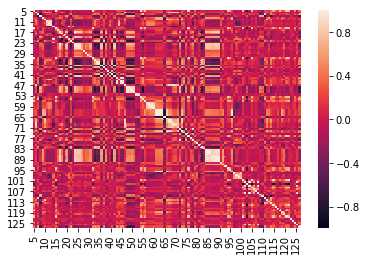

In [97]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr)

# Выводы

Если признак коррелирует с целевой переменной, то он оказывает благоприятное воздействие на линейную регрессию. 

Если же коррелируют два простых признака, то это указывет на ненужность одного из них - наличие коррелирующих признаков может повлиять на процесс обучения и, как мне кажется, даже привести к переобучению.

В нашем же датасете, судя по визуализации корреляции, не так много признаков второго типа (коррелирующих не с целевой переменной)

#### 2. (0.5 балла) Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

In [98]:
corr_data = corr[127].sort_values()

print('Min корреляция у признака:', corr_data.index[0])
print('Max корреляция у признака:', corr_data.index[-2])

Min корреляция у признака: 49
Max корреляция у признака: 55


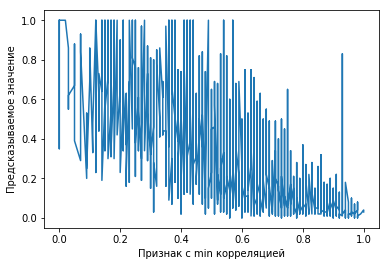

In [99]:
data_sort1 = data.sort_values(by=[corr_data.index[0]])
plt.plot(data_sort1[corr_data.index[0]].values, data_sort1[127].values)
plt.xlabel('Признак с min корреляцией')
plt.ylabel('Предсказываемое значение')
plt.show()

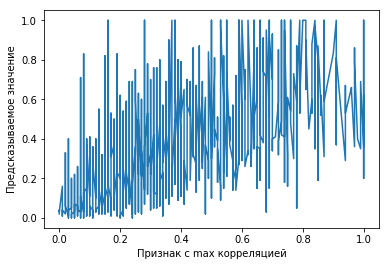

In [100]:
data_sort1 = data.sort_values(by=[corr_data.index[-2]])
plt.plot(data_sort1[corr_data.index[-2]].values, data_sort1[127].values)
plt.xlabel('Признак с max корреляцией')
plt.ylabel('Предсказываемое значение')
plt.show()

#### 3. (0.5 балла) Постройте гистограмму распределения предсказываемого значения.

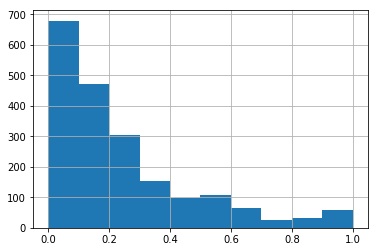

In [101]:
data[127].hist()

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. (0.5 балла) Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [102]:
for i in range(5, 5 + data.shape[1]):
    data[i] = data[i].fillna(data[i].mean())
data

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
5,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,0.37,...,0.01,0.58,0.10,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.14
6,0.01,0.39,0.00,0.98,0.06,0.02,0.30,0.37,0.23,0.60,...,0.05,0.08,0.06,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
7,0.01,0.74,0.03,0.46,0.20,1.00,0.52,0.55,0.36,0.35,...,0.01,0.33,0.00,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.55
8,0.03,0.34,0.20,0.84,0.02,0.00,0.38,0.45,0.28,0.48,...,0.04,0.17,0.04,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.53
9,0.01,0.40,0.06,0.87,0.30,0.03,0.90,0.82,0.80,0.39,...,0.00,0.47,0.11,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.15


Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество (Три части необходимы для бонусной части) В базовой части GridSearchCV необходимо делать на (X_train_new, y_train_new)

In [103]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [104]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [105]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. (0.5 балла) Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [106]:
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)
y_pred = LR.predict(X_test)
err = mean_squared_error(y_test, y_pred)
print(err)

0.018535728690394045


#### 6. (0.5 балла) Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [134]:
from sklearn.model_selection import GridSearchCV

Ridge = lm.Ridge()
param = {'alpha':[0.001, 0.01, 0.1, 1, 2, 3, 10, 100]}
grid_search = GridSearchCV(Ridge, param_grid=param, cv = 5)
grid_search.fit(X_train_new, y_train_new)
grid_search.best_params_

{'alpha': 10}

In [135]:
Lasso = lm.Lasso()
param = {'alpha':[0.001, 0.01, 0.1, 1, 2, 3, 10, 100]}
grid_search = GridSearchCV(Lasso, param_grid=param, cv = 5)
grid_search.fit(X_train_new, y_train_new)
grid_search.best_params_

{'alpha': 0.001}

Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [136]:
Ridge = lm.Ridge(alpha = 10)
Ridge.fit(X_train_new, y_train_new)
Ridge.coef_

array([ 1.32415971e-04,  6.87963886e-03,  1.25126907e-01, -7.84704998e-02,
       -4.05361589e-02,  1.32452166e-02,  1.08025810e-03, -3.02480909e-02,
       -9.22257554e-03,  1.26266659e-02,  4.20167432e-04,  4.17198143e-02,
        1.78334641e-02, -4.13345030e-02,  7.69298241e-03, -6.19555489e-02,
        1.33556962e-02,  3.48327521e-02, -4.23594232e-02,  2.59642077e-03,
       -5.29125685e-03, -1.49829865e-02, -2.73381314e-02, -2.46776235e-02,
        1.99521177e-02,  4.68238853e-02,  1.14857447e-02,  5.19276007e-03,
       -3.55450092e-02, -2.11452279e-02,  1.92263416e-02, -9.96074408e-03,
       -1.63674080e-02,  2.60504221e-02, -2.63093974e-02, -1.05573502e-02,
        2.57066917e-02, -5.88427555e-03,  6.82620018e-02,  3.40376632e-02,
       -1.51779086e-05,  2.61943044e-02,  3.57599857e-03, -6.11428355e-02,
       -8.58375627e-02, -5.58646446e-02, -5.59813177e-02, -1.24125866e-02,
       -6.02056149e-02,  1.28054519e-02,  1.41340608e-01, -1.15601595e-02,
       -1.29040725e-02, -

In [137]:
y_pred = Ridge.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.017250862751055654


In [127]:
Lasso = lm.Lasso(alpha = 0.001)
Lasso.fit(X_train_new, y_train_new)
lc = Lasso.coef_
print(lc)

[ 0.          0.          0.11930398 -0.05810877 -0.          0.
 -0.         -0.         -0.          0.          0.          0.03721557
  0.         -0.01022747  0.         -0.00737757  0.          0.00074345
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.01925606  0.          0.         -0.          0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.14822345 -0.          0.          0.
  0.         -0.         -0.22663087 -0.         -0.         -0.
 -0.06701046  0.          0.23159175  0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.01414729
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.12656154  0.          0.          0.10289679
 -0.05931883  0.          0.02853992 -0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.014856

In [128]:
y_pred = Lasso.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.0173708460734664


Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [129]:
X_train_supernew = []
y_train_supernew = []
for i in range(len(lc)):
    if(lc[i] != 0. and lc[i] != -0.):
        X_train_supernew.append(X_train_new[i])
        y_train_supernew.append(y_train_new[i])

In [130]:
Ridge = lm.Ridge(alpha = 10)
Ridge.fit(X_train_supernew, y_train_supernew)
y_pred = Ridge.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.030249275406513208


In [131]:
Lasso = lm.Lasso(alpha = 0.001)
Lasso.fit(X_train_supernew, y_train_supernew)
y_pred = Lasso.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.04236501709021564


# Выводы

Получается, что при отборе наиболее релевантных признаков метод Lasso совершает больше ошибок. Следовательно, что мы не можем просто так выкидывать неподходящие нам признаки и обучать модель только на оставшихся данных - параметр alpha был получен с учётом всех признаков, что могло повлиять на такой исход.

#### 7. (0.5 балла) Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [132]:
clf = KNeighborsRegressor()
clf.fit(X_train_new, y_train_new)
y_pred = clf.predict(X_test)
err = mean_squared_error(y_test, y_pred)
print(err)

0.019501855421686743


#### 8. (0.5 балла) Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [118]:
knn = KNeighborsRegressor()
param = {'n_neighbors':[6, 8], 'p':[1, 2, 3]}
grid_search = GridSearchCV(knn, param_grid=param, cv = 5)
grid_search.fit(X_train_new, y_train_new)
grid_search.best_params_

{'n_neighbors': 8, 'p': 1}

In [121]:
knn = KNeighborsRegressor(n_neighbors = 8, p = 1)
knn.fit(X_train_supernew, y_train_supernew)
y_pred = knn.predict(X_test)
err = mean_squared_error(y_test, y_pred)
print(err)

0.034503303840361446


С помощью какого алгоритма удалось достичь лучшего качества?

С помощью метода Ridge-регрессии при alpha = 10 и при неотобранных признаках.

#### (2 балла) Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

В исследованном датасете оказалось довольно-таки мало коррелирующих признаков (данный вывод был получен с помощью вычисления и визуализации попарной корреляции Пирсона между всеми признаками). Это означает, что на процесс обучения не будет влиять корреляция. Стоит отдельно подчеркнуть, что у некоторых признаков наблюдается корреляция с целевой переменной, что благотворно влияет на весь процесс обучения.

В предложенном датасете оказалось достаточно много пропущенных значений. Для работы с регрессионными методами нам пришлось избавиться от них на этапе предобработки данных

Выполнение алгоритмов различных методов обучения показало, что на предложенных данных точнее всего оказывается метод Ridge-регрессии при вычисленном оптимального значения гиперпараметра alpha = 10. ДЛя Lasso оптимальный параметр alpha = 0.0001. 

Для метода KNN наиболее подходящим K = 8 и p = 1.

Также было получено, что при отборе наиболее релевантных признаков метод Lasso совершает больше ошибок. К тому же, для Lasso многие из признаков оказались нерелевантными, что было получено из анализа 